**Importing necessary packages and libraries**

In [1]:
import numpy as np                                                                        
import pandas as pd  
import os
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE                 #imblearn package is imported for under and over sampling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB,CategoricalNB
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.utils import shuffle
from sklearn.feature_selection import chi2, SelectKBest
import time

np.random.seed(42)

# **Reading data**

In [2]:
file_path = 'bank-data/bank-data/bank-additional-full.csv'
data = pd.read_csv(file_path,sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# **Exploratory Data Analysis**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

So, our data does not contain any missing values which is good. However, upon further inspection there are some columns which has the value **'unknown'**. Since the data is about bank clients, it is possible realistically to have some **'unknown'** values for the client. But we still have to predict if the client will subscribe to a new term. Hence, I am considering it as an attribute value and not treating the **'unknown'** values as missing values.

In [4]:
data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

So, the dataset is highly imbalanced with class 'no' having around 88.7% of the data.
Let's look at the histograms of each numeric variables to have an idea about those attributes.

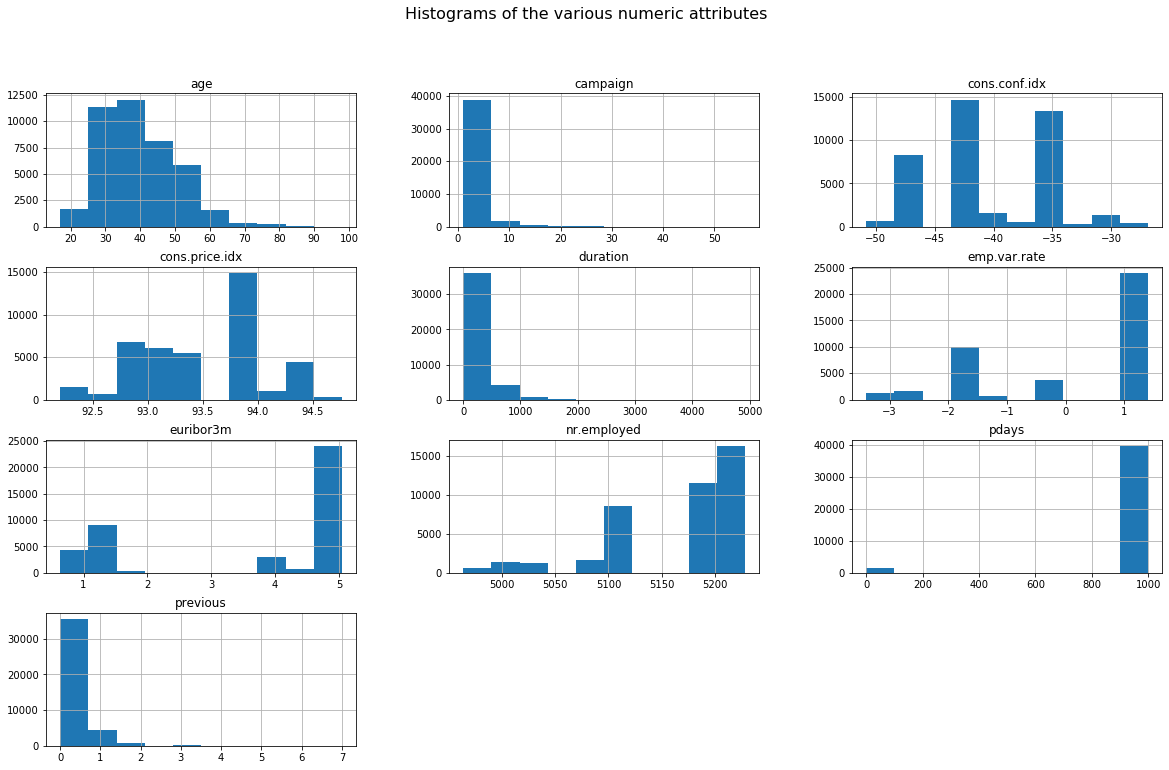

In [5]:
data.hist(figsize = (20,12))
plt.suptitle('Histograms of the various numeric attributes',fontsize = 16)

plt.show()

From the histogram of the various numeric attributes, it is evident that **pdays** should be a categorical and ordinal attribute. The value **999** means that the client was not previously contacted and hence is encoded 0. The other values are also encoded according to groups with the ordered value being higher if the client was recently contacted. **euribor3m**, **nr.employed** and **emp.var.rate** can also be considered as ordinal attributes.

Intuitively, **day_of_week** and **months** columns can be dropped as they are nothing but related to the date when the client was last contacted and hence we do not believe that it is an important feature given that we already have the features **pdays** and **campaign** which encodes the information about last contact of the client. So we have dropped the columns **day_of_week** and **months** for our preprocessing. 

Out of the categorical columns, **poutcome** is obviously an ordinal feature as if the outcome of the previous marketting campaign was a _success_ for the client then client is more likely to subscribe again than if it was a _failure_. So, we encode the _success_ with a high value, _failure_ with a low value and _unknown_ with a value in between. Similarly, we encode **default** as a person with default credit is less likely to subscribe than a person with no default. So we encode _no_ value of **default** with a high value, _yes_ value with a low value and _unknown_ with a value in between. We use the exact same encoding for **housing** and **loan** too as these attributes are also similar to **default**.

The remaining categorical columns are kept as nominal columns as I was unsure about the order with which to encode the attribute values. For example, **education** seems like an ordinal attribute but I was not sure about the order of its values. 

Let's do some feature selection to see which features are important for our classifier. I am going to use chi score test to see if an attribute is an important feature or not. My Null Hypothesis is that the attribute is independent of the target variable. If we get a high P-value we can drop that attribute as it is not an important feature. I am going to use the chi2 function available in sklearn's feature selection module which returns the chi scores and pvalues for the set of attributes.

# Feature Selection

In [6]:
numeric_columns = data._get_numeric_data().columns
categorical_columns = set(data.columns) - set(numeric_columns)

cat_data = data[categorical_columns].copy()
num_data = data[numeric_columns].copy()

for var in categorical_columns:
    cat_data[var] = LabelEncoder().fit_transform(cat_data[var].values)

cat_data

,contact,month,education,default,loan,marital,poutcome,housing,job,day_of_week,y
0,1,6,0,0,0,1,1,0,3,1,0
1,1,6,3,1,0,1,1,0,7,1,0
2,1,6,3,0,0,1,1,2,7,1,0
3,1,6,1,0,0,1,1,0,0,1,0
4,1,6,3,0,2,1,1,0,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...
41183,0,7,5,0,0,1,1,2,5,0,1
41184,0,7,5,0,0,1,1,0,1,0,0
41185,0,7,6,0,0,1,1,2,5,0,0
41186,0,7,5,0,0,1,1,0,9,0,1


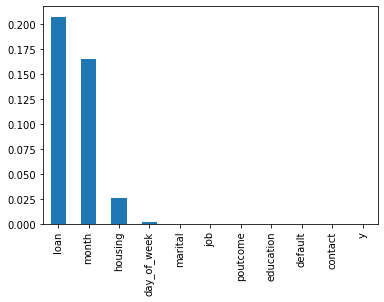

In [7]:
y = cat_data['y'].values
cat_data.drop('y',axis =1)

chi_scores = chi2(cat_data, y)
p_values = pd.Series(chi_scores[1],index = cat_data.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot(kind = 'bar')
plt.show()

Since, the pvalues of **loan**, **month**, **housing** and **day_of_week** are higher than rest, they can be dropped.

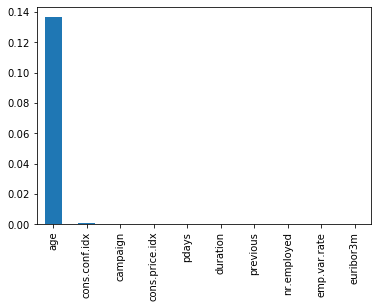

In [8]:
numeric_data = MinMaxScaler().fit_transform(num_data)
chi_scores = chi2(numeric_data, y)

p_values = pd.Series(chi_scores[1],index = num_data.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot(kind = 'bar')
plt.show()

Since, **age** has a higher pvalue with respect to others, it can be dropped. Let's see what are the 10 best features with sklearn's SelectKBest module using chi score as the function.

In [9]:
c_data = data.copy()

c_data[list(categorical_columns)] = cat_data
c_data[list(numeric_columns)] = numeric_data


c_data.drop('y',axis=1,inplace = True)
c_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.481481,3,1,0,0,0,0,1,6,1,0.053070,0.000000,1.0,0.000000,1,0.937500,0.698753,0.60251,0.957379,0.859735
1,0.493827,7,1,3,1,0,0,1,6,1,0.030297,0.000000,1.0,0.000000,1,0.937500,0.698753,0.60251,0.957379,0.859735
2,0.246914,7,1,3,0,2,0,1,6,1,0.045954,0.000000,1.0,0.000000,1,0.937500,0.698753,0.60251,0.957379,0.859735
3,0.283951,0,1,1,0,0,0,1,6,1,0.030704,0.000000,1.0,0.000000,1,0.937500,0.698753,0.60251,0.957379,0.859735
4,0.481481,7,1,3,0,0,2,1,6,1,0.062424,0.000000,1.0,0.000000,1,0.937500,0.698753,0.60251,0.957379,0.859735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.691358,5,1,5,0,2,0,0,7,0,0.067914,0.000000,1.0,0.000000,1,0.479167,1.000000,0.00000,0.089322,0.000000
41184,0.358025,1,1,5,0,0,0,0,7,0,0.077877,0.000000,1.0,0.000000,1,0.479167,1.000000,0.00000,0.089322,0.000000
41185,0.481481,5,1,6,0,2,0,0,7,0,0.038430,0.018182,1.0,0.000000,1,0.479167,1.000000,0.00000,0.089322,0.000000
41186,0.333333,9,1,5,0,0,0,0,7,0,0.089874,0.000000,1.0,0.000000,1,0.479167,1.000000,0.00000,0.089322,0.000000


In [10]:
best_features_10 = SelectKBest(chi2,k=10)
best_features_10.fit(c_data, y)
c_data.columns[best_features_10.get_support()]

Index(['education', 'default', 'contact', 'duration', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed'],
      dtype='object')

So, we can see the best 10 features above. So let's see the features we can drop by seeing the complement of the above set from our columns set.

In [11]:
set(c_data.columns) - set(c_data.columns[best_features_10.get_support()])

{'age',
 'campaign',
 'cons.conf.idx',
 'cons.price.idx',
 'day_of_week',
 'housing',
 'job',
 'loan',
 'marital',
 'month'}

So, we are going to drop all of the above columns and keep the remaining as our useful features and build our model on that.

# **Preprocessing data according to EDA and Feature Selection**

In [12]:
def pdays_map(x):
    if x==999:
        return 0
    elif 0<=x<=5:
        return 4
    elif 6<=x<=10:
        return 3
    elif 11<=x<=15:
        return 2
    else:
        return 1

def preprocess1(df = data):
    numeric_columns = list(df._get_numeric_data().columns)
    categorical_columns = list(set(df.columns) - set(numeric_columns))
    categorical_columns.remove('y')

    categorical_columns.remove('day_of_week')
    categorical_columns.remove('month')
    categorical_columns.remove('marital')
    categorical_columns.remove('housing')
    categorical_columns.remove('loan')
    categorical_columns.remove('job')
    
    
    
    numeric_columns.remove('campaign')
    numeric_columns.remove('cons.conf.idx')
    numeric_columns.remove('cons.price.idx')
    numeric_columns.remove('age')

    ordinal_categories = []

    df['pdays_cat'] = df['pdays'].apply(pdays_map)
    ordinal_categories.append('pdays_cat')
    numeric_columns.remove('pdays')

    poutcome_map = {'success':2,'nonexistent':1,'failure':0}
    df['poutcome'] = df['poutcome'].apply(lambda x:poutcome_map[x])
    #data['poutcome'].value_counts()

    ordinal_categories.append('poutcome')

    default_map = {'no':2, 'yes':0, 'unknown':1}
    df['default'] = df['default'].apply(lambda x:default_map[x])

    ordinal_categories.append('default')

    
    contact_map = {'cellular':0,'telephone':1}
    df['contact'] = df['contact'].apply(lambda x:contact_map[x])
    ordinal_categories.append('contact')

    nominal_categories = list(set(categorical_columns) - set(ordinal_categories))
    print ('Numeric columns:', numeric_columns)
    print ('Ordinal columns:', ordinal_categories)
    print ('Nominal columns:', nominal_categories)
    ordinal_data = df[ordinal_categories]
    nominal_data = df[nominal_categories]
    numeric_data = df[numeric_columns]

    df2 = pd.concat([ordinal_data,nominal_data,numeric_data],axis=1)
    target_map = {'yes':1,'no':0}
    df2['y'] = df['y'].apply(lambda x:target_map[x])

    return (df2,ordinal_categories,nominal_categories,numeric_columns)

In [13]:
p_data, ordinal_categories, nominal_categories, numeric_columns = preprocess1(data)
data_y = p_data['y'].values
data_x = p_data.drop('y',axis=1)
print (data_x.shape, data_y.shape)

Numeric columns: ['duration', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']
Ordinal columns: ['pdays_cat', 'poutcome', 'default', 'contact']
Nominal columns: ['education']
(41188, 10) (41188,)


After the level 1 preprocessing of we further need to encode the nominal features into One Hot Encoding. Further, I have normalized the numeric data by using:
$\frac{feature\_value - feature\_mean}{feature\_standard\_deviation}$.

For the ordinal data, I have done a normalization to a scale of 0 to 1 by applying:
$\frac{feature\_value - feature\_min}{feature\_max - feature\_min}$.

In [14]:
def preprocess2(df, ordinal_categories, nominal_categories, numeric_columns):
    ordinal_data = df[ordinal_categories]
    nominal_data = df[nominal_categories]
    numeric_data = df[numeric_columns]

    encoder = OneHotEncoder()
    nominal_data = encoder.fit_transform(nominal_data).toarray()

   
    numeric_data = StandardScaler().fit_transform(numeric_data)
    ordinal_data = MinMaxScaler().fit_transform(ordinal_data)

    x = np.append(numeric_data,ordinal_data,axis=1)
    x = np.append(nominal_data,x,axis=1)

    return x

In [15]:
data_x, data_y = shuffle(data_x,data_y,random_state = 42)
data_x  = preprocess2(data_x,ordinal_categories, nominal_categories, numeric_columns)

**Getting a stratified 10 fold split of the data** 

Since the dataset is highly skewed, it is necessary to perform stratified sampling while splitting for train and test set. Also, in this experiment we are going to evaluate our classifiers by 10-fold cross validation scores. So, it is necessary to perform a 10 fold stratified cross validation to correctly evaluate our classifier.

In [16]:

kf = StratifiedKFold(n_splits = 10,shuffle = True, random_state=42)
kf.get_n_splits(data_x,data_y)
print (kf)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


# **Building classifiers and searching for the best hyperparameters using GridSearchCV**

**Decision Tree Classifier**

In [18]:
print ('Finding best hyperparameters for accuracy of Decision Tree Classifier')
t0 = time.time()
tree = DecisionTreeClassifier()
parameters = {
'criterion':['gini','entropy'],
'max_depth':[10,20,30],
'min_samples_split':[5,10,20],
'max_leaf_nodes': [10,20,30]
}
clf = GridSearchCV(tree,parameters,cv = 10,scoring = 'accuracy')
clf.fit(data_x,data_y)

print(clf.best_estimator_)
#print (clf.cv_results_)
print ('Time taken = %f' %(time.time()-t0))

Finding best hyperparameters for accuracy of Decision Tree Classifier
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=30,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Time taken = 68.826180


Using these hyperparameters for our classifier

In [17]:
start = time.time()
clf = DecisionTreeClassifier(criterion='entropy',max_depth = 20, max_leaf_nodes = 30, min_samples_split = 5)
cv = cross_validate(clf,data_x,data_y,cv=kf,scoring=['accuracy','precision','recall','f1'])

print ('Average accuracy = %f' %(np.mean(cv['test_accuracy'])))

print ('Average precision of class yes= %f' %(np.mean(cv['test_precision'])))

print ('Average recall of class yes= %f' %(np.mean(cv['test_recall'])))

print ('Average F1 score of class yes = %f' %(np.mean(cv['test_f1'])))

end = time.time()
print ('Time taken = %s seconds' %(end-start))

Average accuracy = 0.915218
Average precision of class yes= 0.630217
Average recall of class yes= 0.598922
Average F1 score of class yes = 0.613967
Time taken = 2.5909810066223145 seconds


**Naive Bayes Classifier**

In [21]:
print ('Finding best hyperparameters for accuracy of Naive Bayes Classifier')
t0 = time.time()
tree = GaussianNB()
parameters = {
'var_smoothing': [1e-3,1e-2,5e-2,1e-1,5e-1,1,2] 
}
clf = GridSearchCV(tree,parameters,cv = 2,scoring = 'accuracy')
clf.fit(data_x,data_y)

print(clf.best_estimator_)
#print (clf.cv_results_)
print ('Time taken = %f' %(time.time()-t0))

Finding best hyperparameters for accuracy of Naive Bayes Classifier
GaussianNB(priors=None, var_smoothing=1)
Time taken = 0.821330


In [22]:
start = time.time()
clf = GaussianNB(var_smoothing = 1)
cv = cross_validate(clf,data_x,data_y,cv=kf,scoring=['accuracy','precision','recall','f1'])

print ('Average accuracy = %f' %(np.mean(cv['test_accuracy'])))

print ('Average precision of class yes= %f' %(np.mean(cv['test_precision'])))

print ('Average recall of class yes= %f' %(np.mean(cv['test_recall'])))

print ('Average F1 score of class yes = %f' %(np.mean(cv['test_f1'])))

end = time.time()
print ('Time taken = %s seconds' %(end-start))

Average accuracy = 0.896596
Average precision of class yes= 0.578115
Average recall of class yes= 0.303879
Average F1 score of class yes = 0.398102
Time taken = 0.6619341373443604 seconds


**Support Vector Machine**

In [53]:
t0 = time.time()
svc = SVC()
parameters = {
'kernel':['rbf'],
'C': [0.7,1,5],
'gamma':[0.0001, 0.001, 0.01, 0.1]
}
clf = GridSearchCV(svc,parameters,cv = 2,scoring = 'accuracy')
clf.fit(data_x,data_y)

print(clf.best_estimator_)
print ('Time taken = %f seconds' %(time.time()-t0))

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Time taken = 190.833583 seconds


Using these hyperparameters for SVC classifier

In [23]:
start = time.time()
clf = SVC(kernel='rbf',C=5,gamma=0.1)
cv = cross_validate(clf,data_x,data_y,cv=kf,scoring=['accuracy','precision','recall','f1'])

print ('Average accuracy = %f' %(np.mean(cv['test_accuracy'])))

print ('Average precision of class yes= %f' %(np.mean(cv['test_precision'])))

print ('Average recall of class yes= %f' %(np.mean(cv['test_recall'])))

print ('Average F1 score of class yes = %f' %(np.mean(cv['test_f1'])))

end = time.time()
print ('Time taken = %s seconds' %(end-start))

Average accuracy = 0.912426
Average precision of class yes= 0.679816
Average recall of class yes= 0.421767
Average F1 score of class yes = 0.520329
Time taken = 347.262264251709 seconds


# **Improving recall**

We got good accuracies but accuracy is misleading in such an imbalanced dataset as this. Here, recall is a much better metric to evaluate our classifier if we think in perspective of the bank. Since, we are trying to predict if a client will subscribe to a marketting campaign term and most of the clients do not subscribe, our predictor should try to catch all potential subscribers. That would bring much more profit to the bank. So, the model should have less number of false negatives. This is the assumption with which I am going to move on in this assignment and use various techniques to maximize the recall. 

## **Class weights**

The main reason for poor recall is that when the data is so imbalanced as this, the classifier would overfit on the major frequency class. So, we should look for various methods to reduce overfitting. **Class weights** is such a technique which can penalize misclassification of the lower frequent class by giving it more weight than the more frequent class. 

In [24]:
def compute_class_weights(y):
    n_classes = len(np.unique(y))
    c = dict(Counter(y))
    t = c[0] + c[1]
    c[0] = t/(n_classes * c[0])
    c[1] = t/(n_classes * c[1])
    return c


c = compute_class_weights(data_y)

Let's re-evaluate our classifiers again by using class weights. Unfortunately Naive Bayes Classifier does not support class weights. So we are only going to evaluate on Decision Tree and SVM.

**Decision Tree Classifier**

In [25]:
start = time.time()
clf = DecisionTreeClassifier(criterion='entropy',max_depth = 20, max_leaf_nodes = 30, min_samples_split = 5,class_weight = c)
cv = cross_validate(clf,data_x,data_y,cv=kf,scoring=['accuracy','precision','recall','f1'])

print ('Average accuracy = %f' %(np.mean(cv['test_accuracy'])))

print ('Average precision of class yes= %f' %(np.mean(cv['test_precision'])))

print ('Average recall of class yes= %f' %(np.mean(cv['test_recall'])))

print ('Average F1 score of class yes = %f' %(np.mean(cv['test_f1'])))

end = time.time()
print ('Time taken = %s seconds' %(end-start))

Average accuracy = 0.819996
Average precision of class yes= 0.381572
Average recall of class yes= 0.951724
Average F1 score of class yes = 0.544284
Time taken = 1.63358473777771 seconds


**SVM**

In [26]:
start = time.time()
clf = SVC(kernel='rbf',C=5,gamma=0.1,class_weight = c)
cv = cross_validate(clf,data_x,data_y,cv=kf,scoring=['accuracy','precision','recall','f1'])

print ('Average accuracy = %f' %(np.mean(cv['test_accuracy'])))

print ('Average precision of class yes= %f' %(np.mean(cv['test_precision'])))

print ('Average recall of class yes= %f' %(np.mean(cv['test_recall'])))

print ('Average F1 score of class yes = %f' %(np.mean(cv['test_f1'])))

end = time.time()
print ('Time taken = %s seconds' %(end-start))

Average accuracy = 0.836676
Average precision of class yes= 0.402534
Average recall of class yes= 0.926293
Average F1 score of class yes = 0.561124
Time taken = 579.7903439998627 seconds


## Under Sampling from Majority Class

So, we can see that the recall has improved by using **class weights** and hence this is a better model for our purpose. I am going to further try other techniques to improve recall. In such heavily imbalanced datasets we can use techniques like **under sampling from the majority class**. So from our stratified 10 fold split, we are going to keep one part as the test data like we usually do where the target label distribution is same as the dataset. From the remaining 9 folds which is the train data, we are going to **Randomly Under sample** from the majority class and have a classifier trained on a balanced class distribution where number of **yes** examples is same as the number of **no** examples. We use that classifier to predict on the the test data. We do this 10 times with each fold being considered once as the test data and report the average recall. For undersampling we are using the package **imblearn** which has the function **RandomUnderSampler**.

**Decision Tree Classifier**

In [27]:
# Helper function to plot the confusion matrices of each test split
def plot_confusion_matrix(row,column,cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):


    #accuracy = np.trace(cm) / np.sum(cm).astype('float')
    #misclass = 1 - accuracy
    target_names = ['no','yes']
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    #plt.figure(figsize=(8, 6))
    axs[row,column].imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        axs[row,column].set_xticks(tick_marks)
        axs[row,column].set_xticklabels(target_names)
        axs[row,column].set_yticks(tick_marks)
        axs[row,column].set_yticklabels(target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            axs[row,column].text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            axs[row,column].text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")



    axs[row,column].set_ylabel('True label')
    axs[row,column].set_xlabel('Predicted label')

In [30]:
i = 0
accuracies = []
precisions = []
recalls = []
f1s = []
cms = []
start = time.time()
for train_index, test_index in kf.split(data_x,data_y):

    i+=1
    train_x, train_y = data_x[train_index].copy(), data_y[train_index].copy()
    test_x, test_y = data_x[test_index].copy(), data_y[test_index].copy()
    
    temp = Counter(train_y)
    #print (temp)
    #over = SMOTE(sampling_strategy = {0:temp[0],1:temp[0]//4}, k_neighbors = 9,random_state = 42)
    #train_x, train_y = over.fit_resample(train_x, train_y)
    
    under = RandomUnderSampler(sampling_strategy = 'majority', random_state = 42)
    train_x, train_y = under.fit_resample(train_x, train_y)

    if i==1:
        print ('Distribution of target variables after sampling')
        print (Counter(train_y))

    #clf = DecisionTreeClassifier(criterion = 'entropy',max_depth = 20,min_samples_split = 10,max_leaf_nodes = 20)
    clf = DecisionTreeClassifier(criterion='entropy',max_depth = 20, max_leaf_nodes = 30, min_samples_split = 5)
    clf.fit(train_x,train_y)
    acc = clf.score(test_x,test_y)
    #print ('Accuracy score = %f' %(acc*100))
    accuracies.append(acc)
    y_pred = clf.predict(test_x)
    precision, recall, f1 , _ = precision_recall_fscore_support(test_y,y_pred)
    print ('\nClassification Report of test split %d' %i)
    print (classification_report(test_y,y_pred))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


    cm = confusion_matrix(test_y,y_pred)
    cms.append(cm)

end = time.time()  

Distribution of target variables after sampling
Counter({0: 4176, 1: 4176})

Classification Report of test split 1
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3655
           1       0.37      0.95      0.53       464

    accuracy                           0.81      4119
   macro avg       0.68      0.87      0.70      4119
weighted avg       0.92      0.81      0.84      4119


Classification Report of test split 2
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      3655
           1       0.38      0.95      0.54       464

    accuracy                           0.82      4119
   macro avg       0.69      0.88      0.72      4119
weighted avg       0.92      0.82      0.85      4119


Classification Report of test split 3
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      3655
           1       0.38      0.97      0.55 

In [32]:
print ('Average Accuracy = %f' %(np.mean(accuracies)))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
mean_recalls = np.mean(recalls,axis=0)
mean_precisions = np.mean(precisions,axis = 0)
mean_f1s = np.mean(f1s,axis = 0)

print ('\nMean recall of class no= %f' %(mean_recalls[0]))
print ('\nMean precision of class no= %f' %(mean_precisions[0]))
print ('\nMean f1 of class no= %f' %(mean_f1s[0]))

print ('\nMean recall of class yes= %f' %(mean_recalls[1]))
print ('\nMean precision of class yes= %f' %(mean_precisions[1]))
print ('\nMean f1 of class yes= %f' %(mean_f1s[1]))

print ('\nMacro Average precision of classifier = %f' %(np.sum(mean_precisions)/2))
print ('Macro Average recall of classifier = %f' %(np.sum(mean_recalls)/2))
print ('Macro Average f1 of classifier = %f' %(np.sum(mean_f1s)/2))

print ('\nTime taken = %f seconds' %(end-start))

Average Accuracy = 0.824999

Mean recall of class no= 0.808719

Mean precision of class no= 0.992754

Mean f1 of class no= 0.891202

Mean recall of class yes= 0.953233

Mean precision of class yes= 0.388935

Mean f1 of class yes= 0.551903

Macro Average precision of classifier = 0.690845
Macro Average recall of classifier = 0.880976
Macro Average f1 of classifier = 0.721552

Time taken = 1.137291 seconds


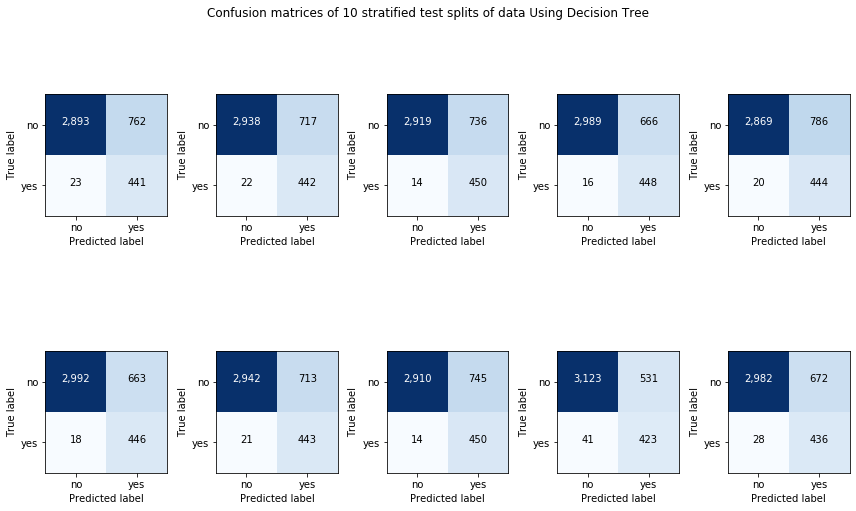

In [33]:
fig, axs = plt.subplots(2,5,figsize=(12,8))
i= 0
j = 0

for cm in cms:
    plot_confusion_matrix(i,j,cm)
    j+=1
    if j==5:
        i+=1
        j = 0
        
plt.tight_layout()
fig.suptitle('Confusion matrices of 10 stratified test splits of data Using Decision Tree')
plt.show()

**Naive Bayes Classifier**

In [57]:
accuracies = []
precisions = []
recalls = []
f1s = []
cms = []

i = 0
start = time.time()
for train_index, test_index in kf.split(data_x,data_y):

    i+=1
    train_x, train_y = data_x[train_index].copy(), data_y[train_index].copy()
    test_x, test_y = data_x[test_index].copy(), data_y[test_index].copy()
    
    temp = Counter(train_y)

    #over = SMOTE(sampling_strategy = {0:temp[0],1:temp[0]//5}, k_neighbors = 9,random_state = 42)
    
    #train_x, train_y = over.fit_resample(train_x, train_y)
    
    under = RandomUnderSampler(sampling_strategy = 'majority')
    train_x, train_y = under.fit_resample(train_x, train_y)

    if i==1:
        print ('Distribution of target variables after sampling')
        print (Counter(train_y))

    clf = GaussianNB(var_smoothing = 0.05)
    clf.fit(train_x,train_y)
    acc = clf.score(test_x,test_y)
    #print ('Accuracy score = %f' %(acc*100))
    accuracies.append(acc)
    y_pred = clf.predict(test_x)
    precision, recall, f1, _ = precision_recall_fscore_support(test_y,y_pred)
    print ('\nClassification Report of test split %d' %i)
    print (classification_report(test_y,y_pred))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


    cm = confusion_matrix(test_y,y_pred)
    cms.append(cm)

end = time.time()

Distribution of target variables after sampling
Counter({0: 4176, 1: 4176})

Classification Report of test split 1
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      3655
           1       0.32      0.78      0.45       464

    accuracy                           0.79      4119
   macro avg       0.64      0.78      0.66      4119
weighted avg       0.89      0.79      0.82      4119


Classification Report of test split 2
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      3655
           1       0.32      0.78      0.45       464

    accuracy                           0.79      4119
   macro avg       0.64      0.78      0.66      4119
weighted avg       0.89      0.79      0.82      4119


Classification Report of test split 3
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      3655
           1       0.31      0.78      0.44 

In [58]:
print ('Average Accuracy = %f' %(np.mean(accuracies)))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
mean_recalls = np.mean(recalls,axis=0)
mean_precisions = np.mean(precisions,axis = 0)
mean_f1s = np.mean(f1s,axis = 0)

print ('\nMean recall of class no= %f' %(mean_recalls[0]))
print ('\nMean precision of class no= %f' %(mean_precisions[0]))
print ('\nMean f1 of class no= %f' %(mean_f1s[0]))

print ('\nMean recall of class yes= %f' %(mean_recalls[1]))
print ('\nMean precision of class yes= %f' %(mean_precisions[1]))
print ('\nMean f1 of class yes= %f' %(mean_f1s[1]))

print ('\nMacro Average precision of classifier = %f' %(np.sum(mean_precisions)/2))
print ('Macro Average recall of classifier = %f' %(np.sum(mean_recalls)/2))
print ('Macro Average f1 of classifier = %f' %(np.sum(mean_f1s)/2))
print ('\nTime Taken = %f seconds' %(end-start))

Average Accuracy = 0.780786

Mean recall of class no= 0.780891

Mean precision of class no= 0.965473

Mean f1 of class no= 0.863365

Mean recall of class yes= 0.779957

Mean precision of class yes= 0.311696

Mean f1 of class yes= 0.445227

Macro Average precision of classifier = 0.638585
Macro Average recall of classifier = 0.780424
Macro Average f1 of classifier = 0.654296

Time Taken = 0.892308 seconds


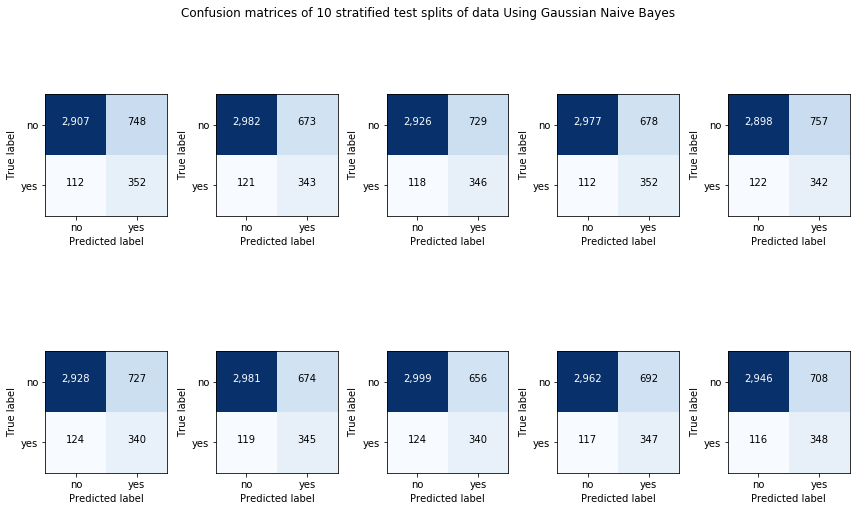

In [54]:
fig, axs = plt.subplots(2,5,figsize=(12,8))
i= 0
j = 0

for cm in cms:
    plot_confusion_matrix(i,j,cm)
    j+=1
    if j==5:
        i+=1
        j = 0
        
plt.tight_layout()
fig.suptitle('Confusion matrices of 10 stratified test splits of data Using Gaussian Naive Bayes')
plt.show()

**SVM Classifier**

In [37]:
accuracies = []
precisions = []
recalls = []
cms = []
f1s = []

i = 0
start = time.time()
for train_index, test_index in kf.split(data_x,data_y):

    i+=1
    train_x, train_y = data_x[train_index].copy(), data_y[train_index].copy()
    test_x, test_y = data_x[test_index].copy(), data_y[test_index].copy()
    
    temp = Counter(train_y)

    #over = SMOTE(sampling_strategy = {0:temp[0],1:temp[0]//6}, k_neighbors = 9,random_state = 42)
    
    #train_x, train_y = over.fit_resample(train_x, train_y)
    
    under = RandomUnderSampler(sampling_strategy = 'majority')
    train_x, train_y = under.fit_resample(train_x, train_y)

    if i==1:
        print ('Distribution of target variables after sampling')
        print (Counter(train_y))

    clf = SVC(kernel='rbf',C= 5 ,gamma = 0.1)
    #clf = SVC(kernel='rbf',C=1,gamma=0.1,class_weight = c)
    clf.fit(train_x,train_y)
    acc = clf.score(test_x,test_y)
    #print ('Accuracy score = %f' %(acc*100))
    accuracies.append(acc)
    y_pred = clf.predict(test_x)
    precision, recall, f1, _ = precision_recall_fscore_support(test_y,y_pred)
    print ('\nClassification Report of test split %d' %i)
    print (classification_report(test_y,y_pred))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


    cm = confusion_matrix(test_y,y_pred)
    cms.append(cm)
    
end = time.time()

Distribution of target variables after sampling
Counter({0: 4176, 1: 4176})

Classification Report of test split 1
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      3655
           1       0.38      0.92      0.54       464

    accuracy                           0.82      4119
   macro avg       0.69      0.87      0.72      4119
weighted avg       0.92      0.82      0.85      4119


Classification Report of test split 2
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      3655
           1       0.39      0.95      0.56       464

    accuracy                           0.83      4119
   macro avg       0.69      0.88      0.72      4119
weighted avg       0.92      0.83      0.86      4119


Classification Report of test split 3
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      3655
           1       0.40      0.91      0.55 

In [40]:
print ('Average Accuracy = %f' %(np.mean(accuracies)))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
mean_recalls = np.mean(recalls,axis=0)
mean_precisions = np.mean(precisions,axis = 0)
mean_f1s = np.mean(f1s,axis = 0)

print ('\nMean recall of class no= %f' %(mean_recalls[0]))
print ('\nMean precision of class no= %f' %(mean_precisions[0]))
print ('\nMean f1 of class no= %f' %(mean_f1s[0]))

print ('\nMean recall of class yes= %f' %(mean_recalls[1]))
print ('\nMean precision of class yes= %f' %(mean_precisions[1]))
print ('\nMean f1 of class yes= %f' %(mean_f1s[1]))

print ('\nMacro Average precision of classifier = %f' %(np.sum(mean_precisions)/2))
print ('Macro Average recall of classifier = %f' %(np.sum(mean_recalls)/2))
print ('Macro Average f1 of classifier = %f' %(np.sum(mean_f1s)/2))
print ('\nTime taken = %f seconds' %(end-start))

Average Accuracy = 0.834830

Mean recall of class no= 0.823438

Mean precision of class no= 0.988507

Mean f1 of class no= 0.898437

Mean recall of class yes= 0.924569

Mean precision of class yes= 0.399528

Mean f1 of class yes= 0.557885

Macro Average precision of classifier = 0.694018
Macro Average recall of classifier = 0.874003
Macro Average f1 of classifier = 0.728161

Time taken = 44.026636 seconds


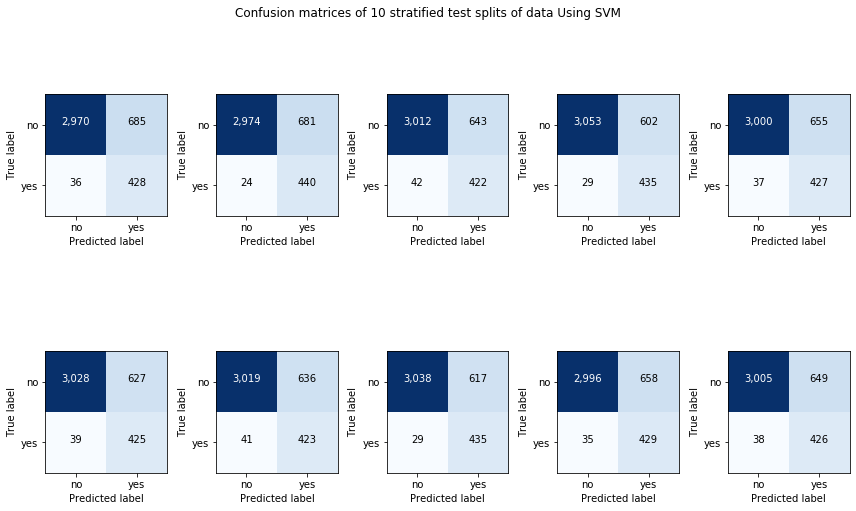

In [39]:
fig, axs = plt.subplots(2,5,figsize=(12,8))
i= 0
j = 0

for cm in cms:
    plot_confusion_matrix(i,j,cm)
    j+=1
    if j==5:
        i+=1
        j = 0
        
plt.tight_layout()
fig.suptitle('Confusion matrices of 10 stratified test splits of data Using SVM')
plt.show()

# Over Sample from minority class and Under Sample from majority class Plus Balanced Class Weight of The Resultant Train Data Target Value Distribution

So from our stratified 10 fold split, we are going to keep one part as the test data like we usually do where the target label distribution is same as the dataset. From the remaining 9 folds which is the train data, we are going to over sample from the minority class to increase its number of examples using **Adaptive Synthetic(ADASYN) Sampling approach** which instead of replicating the minority class examples like in **Random Over Sampling** it generates synthetic data based on the minority class examples based on the nearest neighbour values.Then we are going to **Randomly Under sample** from the majority class and have a classifier trained on a class distribution which **may not be a 50-50 balanced split** but **more balanced than true data distribution**. If the split is not balanced we use **balanced class weight of the train data target value distribution**.  We use that classifier to predict on the the test data. We do this 10 times with each fold being considered once as the test data and report the average recall. For undersampling and oversampling we are using the package **imblearn** which has modules for these tasks.

**Note**: We have to be careful while oversampling from the minority class that we do not oversample too much as that can lead to overfitting. 

**Decision Tree Classifier**

In [41]:
i = 0
accuracies = []
precisions = []
recalls = []
f1s = []
cms = []
start = time.time()
for train_index, test_index in kf.split(data_x,data_y):

    i+=1
    train_x, train_y = data_x[train_index].copy(), data_y[train_index].copy()
    test_x, test_y = data_x[test_index].copy(), data_y[test_index].copy()
    
    temp = Counter(train_y)
    #print (temp)
    #over = SMOTE(sampling_strategy = {0:temp[0],1:temp[0]//5}, k_neighbors = 9,random_state = 42)
    over = ADASYN(sampling_strategy = {0:temp[0],1:temp[0]//6}, n_neighbors = 9,random_state = 42)
    train_x, train_y = over.fit_resample(train_x, train_y)
    
    #temp = Counter(train_y)
    #print (temp)
    
    under = RandomUnderSampler(sampling_strategy = 0.7, random_state = 42)
    train_x, train_y = under.fit_resample(train_x, train_y)

    if i==1:
        print ('Distribution of target variables after sampling')
        print (Counter(train_y))

    #clf = DecisionTreeClassifier(criterion = 'entropy',max_depth = 20,min_samples_split = 10,max_leaf_nodes = 20,class_weight = c)
    clf = DecisionTreeClassifier(criterion='entropy',max_depth = 20, max_leaf_nodes = 30, min_samples_split = 5,class_weight = 'balanced')
    clf.fit(train_x,train_y)
    acc = clf.score(test_x,test_y)
    #print ('Accuracy score = %f' %(acc*100))
    accuracies.append(acc)
    y_pred = clf.predict(test_x)
    precision, recall, f1 , _ = precision_recall_fscore_support(test_y,y_pred)
    print ('\nClassification Report of test split %d' %i)
    print (classification_report(test_y,y_pred))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


    cm = confusion_matrix(test_y,y_pred)
    cms.append(cm)
    
end = time.time()

Distribution of target variables after sampling
Counter({0: 6842, 1: 4790})

Classification Report of test split 1
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3655
           1       0.37      0.95      0.53       464

    accuracy                           0.81      4119
   macro avg       0.68      0.87      0.71      4119
weighted avg       0.92      0.81      0.84      4119


Classification Report of test split 2
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3655
           1       0.37      0.97      0.53       464

    accuracy                           0.81      4119
   macro avg       0.68      0.88      0.71      4119
weighted avg       0.92      0.81      0.84      4119


Classification Report of test split 3
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      3655
           1       0.36      0.97      0.53 

In [42]:
print ('Average Accuracy = %f' %(np.mean(accuracies)))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
mean_recalls = np.mean(recalls,axis=0)
mean_precisions = np.mean(precisions,axis = 0)
mean_f1s = np.mean(f1s,axis = 0)

print ('\nMean recall of class no= %f' %(mean_recalls[0]))
print ('\nMean precision of class no= %f' %(mean_precisions[0]))
print ('\nMean f1 of class no= %f' %(mean_f1s[0]))

print ('\nMean recall of class yes= %f' %(mean_recalls[1]))
print ('\nMean precision of class yes= %f' %(mean_precisions[1]))
print ('\nMean f1 of class yes= %f' %(mean_f1s[1]))

print ('\nMacro Average precision of classifier = %f' %(np.sum(mean_precisions)/2))
print ('Macro Average recall of classifier = %f' %(np.sum(mean_recalls)/2))
print ('Macro Average f1 of classifier = %f' %(np.sum(mean_f1s)/2))
print ('Time taken = %f seconds' %(end-start))

Average Accuracy = 0.816209

Mean recall of class no= 0.797938

Mean precision of class no= 0.993710

Mean f1 of class no= 0.885080

Mean recall of class yes= 0.960129

Mean precision of class yes= 0.376692

Mean f1 of class yes= 0.540941

Macro Average precision of classifier = 0.685201
Macro Average recall of classifier = 0.879033
Macro Average f1 of classifier = 0.713011
Time taken = 25.408980 seconds


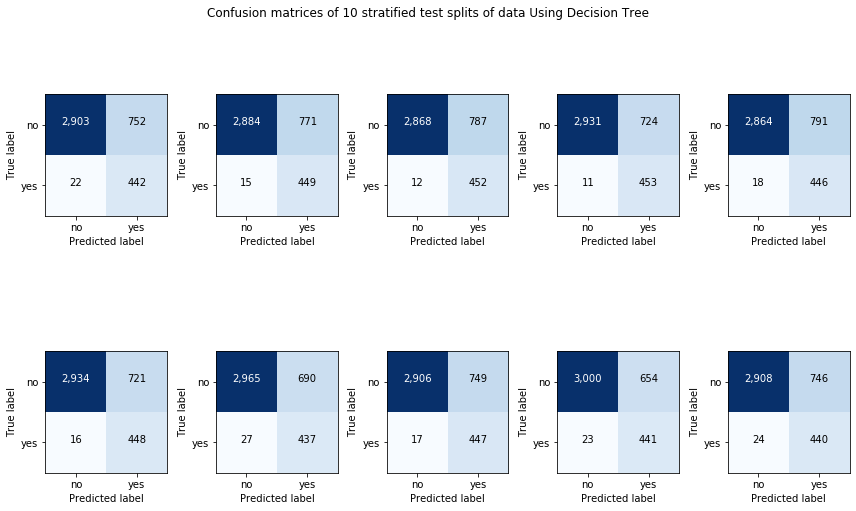

In [43]:
fig, axs = plt.subplots(2,5,figsize=(12,8))
i= 0
j = 0

for cm in cms:
    plot_confusion_matrix(i,j,cm)
    j+=1
    if j==5:
        i+=1
        j = 0
        
plt.tight_layout()
fig.suptitle('Confusion matrices of 10 stratified test splits of data Using Decision Tree')
plt.show()

**Naive Bayes Classifier**

In [44]:
accuracies = []
precisions = []
recalls = []
f1s = []
cms = []

i = 0
start = time.time()
for train_index, test_index in kf.split(data_x,data_y):

    i+=1
    train_x, train_y = data_x[train_index].copy(), data_y[train_index].copy()
    test_x, test_y = data_x[test_index].copy(), data_y[test_index].copy()
    
    temp = Counter(train_y)

    #over = SMOTE(sampling_strategy = {0:temp[0],1:temp[0]//5}, k_neighbors = 9,random_state = 42)
    over = over = ADASYN(sampling_strategy = {0:temp[0],1:temp[0]//6}, n_neighbors = 9,random_state = 42)
    train_x, train_y = over.fit_resample(train_x, train_y)
    
    under = RandomUnderSampler(sampling_strategy = 'majority')
    train_x, train_y = under.fit_resample(train_x, train_y)

    if i==1:
        print ('Distribution of target variables after sampling')
        print (Counter(train_y))

    clf = GaussianNB(var_smoothing = 0.05)
    clf.fit(train_x,train_y)
    acc = clf.score(test_x,test_y)
    #print ('Accuracy score = %f' %(acc*100))
    accuracies.append(acc)
    y_pred = clf.predict(test_x)
    precision, recall, f1, _ = precision_recall_fscore_support(test_y,y_pred)
    print ('\nClassification Report of test split %d' %i)
    print (classification_report(test_y,y_pred))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


    cm = confusion_matrix(test_y,y_pred)
    cms.append(cm)
    
end = time.time()

Distribution of target variables after sampling
Counter({0: 4790, 1: 4790})

Classification Report of test split 1
              precision    recall  f1-score   support

           0       0.97      0.75      0.84      3655
           1       0.29      0.80      0.42       464

    accuracy                           0.75      4119
   macro avg       0.63      0.77      0.63      4119
weighted avg       0.89      0.75      0.80      4119


Classification Report of test split 2
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3655
           1       0.29      0.78      0.43       464

    accuracy                           0.76      4119
   macro avg       0.63      0.77      0.64      4119
weighted avg       0.89      0.76      0.80      4119


Classification Report of test split 3
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      3655
           1       0.30      0.81      0.44 

In [45]:
print ('Average Accuracy = %f' %(np.mean(accuracies)))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
mean_recalls = np.mean(recalls,axis=0)
mean_precisions = np.mean(precisions,axis = 0)
mean_f1s = np.mean(f1s,axis = 0)

print ('\nMean recall of class no= %f' %(mean_recalls[0]))
print ('\nMean precision of class no= %f' %(mean_precisions[0]))
print ('\nMean f1 of class no= %f' %(mean_f1s[0]))

print ('\nMean recall of class yes= %f' %(mean_recalls[1]))
print ('\nMean precision of class yes= %f' %(mean_precisions[1]))
print ('\nMean f1 of class yes= %f' %(mean_f1s[1]))

print ('\nMacro Average precision of classifier = %f' %(np.sum(mean_precisions)/2))
print ('Macro Average recall of classifier = %f' %(np.sum(mean_recalls)/2))
print ('Macro Average f1 of classifier = %f' %(np.sum(mean_f1s)/2))
print ('\nTime taken = %f seconds' %(end-start))

Average Accuracy = 0.767044

Mean recall of class no= 0.763763

Mean precision of class no= 0.966724

Mean f1 of class no= 0.853307

Mean recall of class yes= 0.792888

Mean precision of class yes= 0.299008

Mean f1 of class yes= 0.434173

Macro Average precision of classifier = 0.632866
Macro Average recall of classifier = 0.778326
Macro Average f1 of classifier = 0.643740

Time taken = 24.336231 seconds


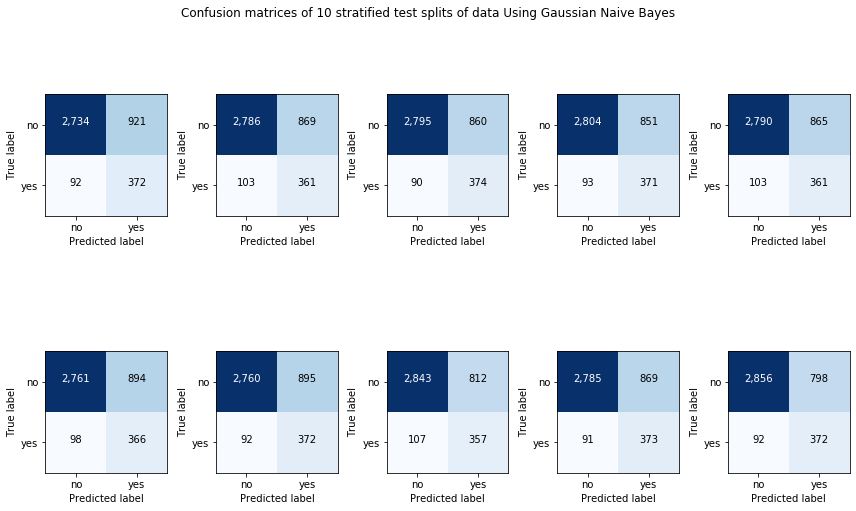

In [46]:
fig, axs = plt.subplots(2,5,figsize=(12,8))
i= 0
j = 0

for cm in cms:
    plot_confusion_matrix(i,j,cm)
    j+=1
    if j==5:
        i+=1
        j = 0
        
plt.tight_layout()
fig.suptitle('Confusion matrices of 10 stratified test splits of data Using Gaussian Naive Bayes')
plt.show()

In [47]:
accuracies = []
precisions = []
recalls = []
cms = []
f1s = []

i = 0
start = time.time()
for train_index, test_index in kf.split(data_x,data_y):

    i+=1
    train_x, train_y = data_x[train_index].copy(), data_y[train_index].copy()
    test_x, test_y = data_x[test_index].copy(), data_y[test_index].copy()
    
    temp = Counter(train_y)

    #over = SMOTE(sampling_strategy = {0:temp[0],1:temp[0]//6}, k_neighbors = 9,random_state = 42)
    over = ADASYN(sampling_strategy = {0:temp[0],1:temp[0]//6}, n_neighbors = 9,random_state = 42)
    
    train_x, train_y = over.fit_resample(train_x, train_y)
    
    under = RandomUnderSampler(sampling_strategy = 0.7)
    train_x, train_y = under.fit_resample(train_x, train_y)

    if i==1:
        print ('Distribution of target variables after sampling')
        print (Counter(train_y))

    clf = SVC(kernel='rbf',C= 5 ,gamma = 0.1, class_weight = 'balanced')
    #clf = SVC(kernel='rbf',C=1,gamma=0.1,class_weight = c)
    clf.fit(train_x,train_y)
    acc = clf.score(test_x,test_y)
    #print ('Accuracy score = %f' %(acc*100))
    accuracies.append(acc)
    y_pred = clf.predict(test_x)
    precision, recall, f1, _ = precision_recall_fscore_support(test_y,y_pred)
    print ('\nClassification Report of test split %d' %i)
    print (classification_report(test_y,y_pred))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


    cm = confusion_matrix(test_y,y_pred)
    cms.append(cm)
    
end = time.time()

Distribution of target variables after sampling
Counter({0: 6842, 1: 4790})

Classification Report of test split 1
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3655
           1       0.36      0.94      0.52       464

    accuracy                           0.81      4119
   macro avg       0.68      0.86      0.70      4119
weighted avg       0.92      0.81      0.84      4119


Classification Report of test split 2
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3655
           1       0.37      0.96      0.53       464

    accuracy                           0.81      4119
   macro avg       0.68      0.88      0.70      4119
weighted avg       0.92      0.81      0.84      4119


Classification Report of test split 3
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      3655
           1       0.37      0.93      0.53 

In [48]:
print ('Average Accuracy = %f' %(np.mean(accuracies)))

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
mean_recalls = np.mean(recalls,axis=0)
mean_precisions = np.mean(precisions,axis = 0)
mean_f1s = np.mean(f1s,axis = 0)

print ('\nMean recall of class no= %f' %(mean_recalls[0]))
print ('\nMean precision of class no= %f' %(mean_precisions[0]))
print ('\nMean f1 of class no= %f' %(mean_f1s[0]))

print ('\nMean recall of class yes= %f' %(mean_recalls[1]))
print ('\nMean precision of class yes= %f' %(mean_precisions[1]))
print ('\nMean f1 of class yes= %f' %(mean_f1s[1]))

print ('\nMacro Average precision of classifier = %f' %(np.sum(mean_precisions)/2))
print ('Macro Average recall of classifier = %f' %(np.sum(mean_recalls)/2))
print ('Macro Average f1 of classifier = %f' %(np.sum(mean_f1s)/2))
print ('\nTime taken = %f seconds' %(end - start))

Average Accuracy = 0.815626

Mean recall of class no= 0.799031

Mean precision of class no= 0.991544

Mean f1 of class no= 0.884916

Mean recall of class yes= 0.946336

Mean precision of class yes= 0.374404

Mean f1 of class yes= 0.536462

Macro Average precision of classifier = 0.682974
Macro Average recall of classifier = 0.872684
Macro Average f1 of classifier = 0.710689

Time taken = 114.140074 seconds


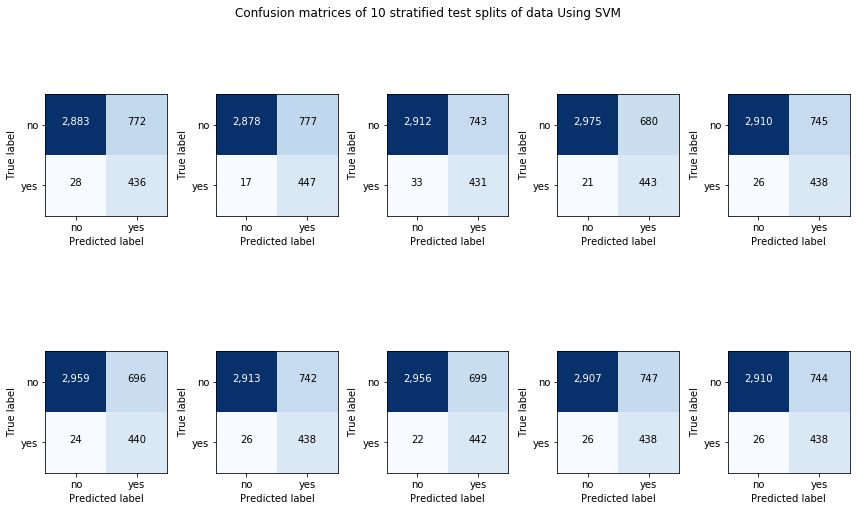

In [49]:
fig, axs = plt.subplots(2,5,figsize=(12,8))
i= 0
j = 0

for cm in cms:
    plot_confusion_matrix(i,j,cm)
    j+=1
    if j==5:
        i+=1
        j = 0
        
plt.tight_layout()
fig.suptitle('Confusion matrices of 10 stratified test splits of data Using SVM')
plt.show()

# **Conclusion and Findings**

Since, the dataset is heavily skewed and for this problem, correctly identifying potential subscribers is much more important than just an overall accuracy which is bound to be overfit due to the data imbalance. From our models, we can also see that not only are our recalls for **'yes'** class very good but also the precision for **'no'** class is great. This means that not only is our model very good at identifying the clients who would actually subscribe to a new term but also if our model predicts that the client won't subscribe to a new term, it is almost definitely true and the bank will not need to waste further resources behind the client in convincing him. Our model has more false positives than the ones without the modifications, but this tradeoff is acceptable for this problem given my assumption that a bank would try to make the client subscribe to a new term anyways and the bank would profit much more if they can correctly identify potential subscribers and hence, false negative would hurt more than false positives and hence a higher recall is preferred.